# Data Loading

In [ ]:
!pip install resampy
!pip uninstall tensorflow
!pip install tensorflow==2.12.0
!pip install keras==2.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.5 MB/s eta 0:00:00
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constrai

In [ ]:
!unzip AudioWAV.zip
!unzip anonym-AudioWAV-2.zip

Streaming output truncated to the last 5000 lines.
  inflating: anonym-AudioWAV-2/1031_DFA_DIS_XX.wav  
  inflating: anonym-AudioWAV-2/1031_DFA_FEA_XX.wav  
  inflating: anonym-AudioWAV-2/1031_DFA_HAP_XX.wav  
  inflating: anonym-AudioWAV-2/1031_DFA_NEU_XX.wav  
  inflating: anonym-AudioWAV-2/1031_DFA_SAD_XX.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_ANG_HI.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_ANG_LO.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_ANG_MD.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_DIS_HI.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_DIS_LO.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_DIS_MD.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_FEA_HI.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_FEA_LO.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_FEA_MD.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_HAP_HI.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_HAP_LO.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_HAP_MD.wav  
  inflating: anonym-AudioWAV-2/1031_IEO_NEU_XX.w

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import resampy
import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
def extract_emotion(filename):
    try:
        parts = filename.split('_')
        return parts[2]  # 'FEA', etc.
    except:
        return 'unknown'

In [ ]:
# Extracting atorID, emotion and path to audio clip
metadata_df = pd.read_csv('crema_d_metadata.csv', sep=';')
metadata_df['emotion'] = metadata_df['relative_path'].apply(extract_emotion)

In [ ]:
metadata_df

,relative_path,speaker_id,gender,emotion
0,AudioWAV/1022_IEO_FEA_MD.wav,1022,Male,FEA
1,AudioWAV/1030_ITS_HAP_XX.wav,1030,Female,HAP
2,AudioWAV/1026_IWL_DIS_XX.wav,1026,Male,DIS
3,AudioWAV/1035_ITH_DIS_XX.wav,1035,Male,DIS
4,AudioWAV/1011_IOM_DIS_XX.wav,1011,Male,DIS
...,...,...,...,...
7437,AudioWAV/1010_WSI_SAD_XX.wav,1010,Female,SAD
7438,AudioWAV/1047_IWW_HAP_XX.wav,1047,Female,HAP
7439,AudioWAV/1073_MTI_NEU_XX.wav,1073,Female,NEU
7440,AudioWAV/1005_WSI_SAD_XX.wav,1005,Male,SAD


# Feature extraction and preprocessing

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Path to your audio folder
audio_dir = 'AudioWAV'  # adjust as needed

# Suppose this is your list of audio file paths
mylist = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
metadata_df = metadata_df.sort_values('relative_path').reset_index(drop=True)
mylist = sorted(mylist)

features = []

for index, y in enumerate(mylist):
    try:
        X, sample_rate = librosa.load(os.path.join(audio_dir, y),
                                      res_type='kaiser_fast',
                                      duration=3,
                                      sr=44100,
                                      offset=0.5)
        spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(spectrogram)
        db_spec = np.pad(db_spec, ((0, 0), (0, 259 - db_spec.shape[1])), mode='constant')
        log_spectrogram = np.mean(db_spec, axis = 0)
        features.append(log_spectrogram)

    except Exception as e:
        print(f"Error processing {y}: {e}")

# Convert to DataFrame
df = pd.DataFrame(features)

In [ ]:
#df = df.drop(columns=['feature'])
X = df
print(X.shape)
y = metadata_df['emotion']

print(X.shape)

(7442, 259)
(7442, 259)


In [ ]:
X = (X-np.mean(X))/np.std(X)

X = np.array(X)
y = np.array(y)

# One hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# 3D tensor
X = X[:,:,np.newaxis]
print(X.shape)

(7442, 259, 1)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [ ]:
print(y)
print(y_encoded)
print(y_onehot)

['ANG' 'DIS' 'FEA' ... 'HAP' 'NEU' 'SAD']
[0 1 2 ... 3 4 5]
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.1, random_state=42, stratify=y_encoded
)

In [ ]:
y_train_indices = np.argmax(y_train, axis=1)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train_indices
)

In [ ]:
print(X_train_train.shape)
print(X_train_val.shape)
print(y_train_train.shape)
print(y_train_val.shape)

(6027, 259, 1)
(670, 259, 1)
(6027, 6)
(670, 6)


# Model instantiation

In [ ]:
def cnn_model(X_train, optimizer):
    model = tf.keras.Sequential()

    model.add(layers.Conv1D(64, kernel_size=10, padding='same', input_shape=(X_train.shape[1], 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv1D(128, kernel_size=5, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))

    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(6, activation='softmax'))

    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
model = cnn_model(X_train_train,'Adam')

# Loading model weights from checkpoint
checkpoint_path = 'trained_best_model.ckpt'
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 64)           704       
                                                                 
 batch_normalization (BatchN  (None, 259, 64)          256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 259, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 128)          41088     
                                                                 
 batch_normalization_1 (Batc  (None, 259, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 259, 128)          0

# Model trainig (optional)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    'trained_best_model.ckpt',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_train, y_train_train,
    validation_data=(X_train_val, y_train_val),
    epochs=30,  # or however many needed
    batch_size=32,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/30
189/189 [==============================] - ETA: 0s - loss: 2.3482 - accuracy: 0.3629
Epoch 1: val_loss improved from inf to 2.09074, saving model to trained_best_model.ckpt
189/189 [==============================] - 35s 173ms/step - loss: 2.3482 - accuracy: 0.3629 - val_loss: 2.0907 - val_accuracy: 0.1940 - lr: 0.0010
Epoch 2/30
188/189 [============================>.] - ETA: 0s - loss: 1.7222 - accuracy: 0.3910
Epoch 2: val_loss improved from 2.09074 to 1.80475, saving model to trained_best_model.ckpt
189/189 [==============================] - 30s 159ms/step - loss: 1.7216 - accuracy: 0.3912 - val_loss: 1.8047 - val_accuracy: 0.3209 - lr: 0.0010
Epoch 3/30
189/189 [==============================] - ETA: 0s - loss: 1.5698 - accuracy: 0.4010
Epoch 3: val_loss improved from 1.80475 to 1.74557, saving model to trained_best_model.ckpt
189/189 [==============================] - 30s 161ms/step - loss: 1.5698 - accuracy: 0.4010 - val_loss: 1.7456 - val_accuracy: 0.3313 - lr: 0.0010

In [ ]:
print(X_test.shape)
print(y_test.shape)

(745, 259, 1)
(745, 6)


# Results

In [ ]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (le.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (le.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[140:150]

24/24 [==============================] - 1s 32ms/step


,Actual Values,Predicted Values
140,DIS,DIS
141,ANG,DIS
142,DIS,DIS
143,SAD,SAD
144,NEU,HAP
145,DIS,DIS
146,ANG,ANG
147,NEU,SAD
148,NEU,NEU
149,DIS,ANG


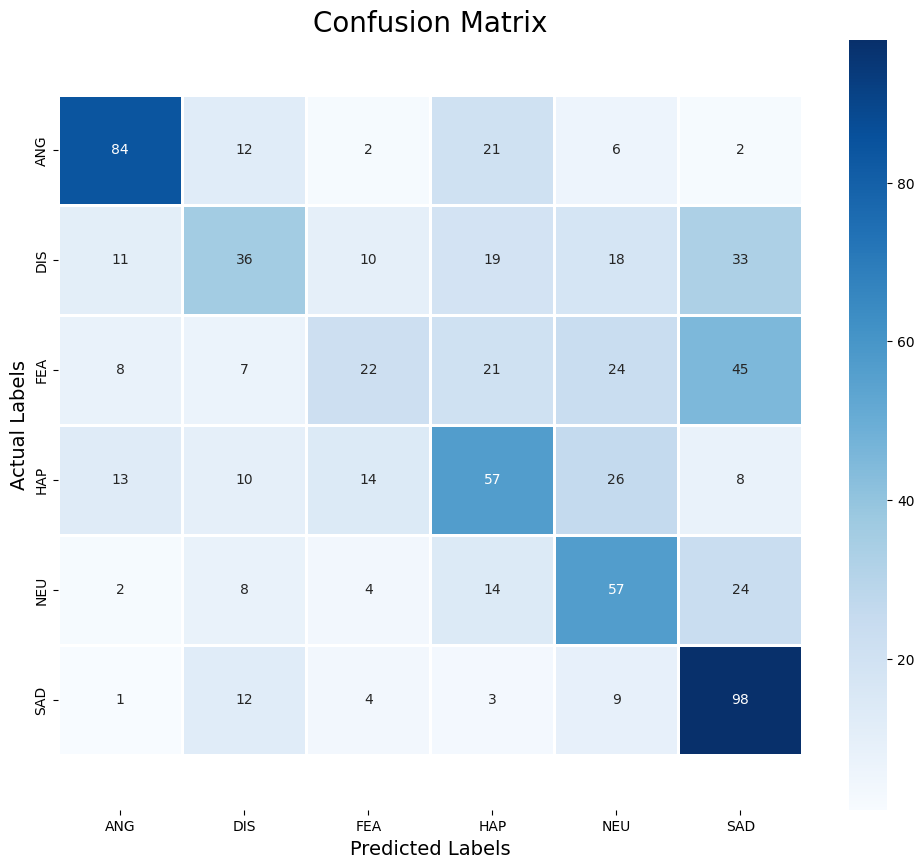

In [ ]:
# Create a confusion matrix of actual vs. prediction labels

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Normal_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

              precision    recall  f1-score   support

         ANG       0.71      0.66      0.68       127
         DIS       0.42      0.28      0.34       127
         FEA       0.39      0.17      0.24       127
         HAP       0.42      0.45      0.43       128
         NEU       0.41      0.52      0.46       109
         SAD       0.47      0.77      0.58       127

    accuracy                           0.48       745
   macro avg       0.47      0.48      0.46       745
weighted avg       0.47      0.48      0.46       745



# Utility

In [ ]:
# Installing necessary dependencies
%%capture
! pip install git+https://github.com/openai/whisper.git
! pip install jiwer

In [ ]:
# Importing modules
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import whisper
from whisper.normalizers import EnglishTextNormalizer
import torch
import jiwer
from tqdm.notebook import tqdm
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Loading whisper model
model = whisper.load_model("medium.en").to(device)
options = whisper.DecodingOptions(language='en', without_timestamps=True)

In [ ]:
train_meta, test_meta = train_test_split(
    metadata_df, test_size=0.1, random_state=42, stratify=metadata_df['emotion']
)
print(test_meta.shape)

(745, 4)


In [ ]:
abbreviation_to_text = {
    "IEO": "It's eleven o'clock",
    "TIE": "That is exactly what happened",
    "IOM": "I'm on my way to the meeting",
    "IWW": "I wonder what this is about",
    "TAI": "The airplane is almost full",
    "MTI": "Maybe tomorrow it will be cold",
    "IWL": "I would like a new alarm clock",
    "ITH": "I think I have a doctor's appointment",
    "DFA": "Don't forget a jacket",
    "ITS": "I think I've seen this before",
    "TSI": "The surface is slick",
    "WSI": "We'll stop in a couple of minutes"
}

In [ ]:
hypotheses = []
references = []

for file_path in test_meta["relative_path"]:
    print(file_path)
    # Extract the abbreviation (e.g., IEO)
    filename = os.path.basename(file_path)
    print(filename)
    parts = filename.split("_")
    abbreviation = parts[1]  # e.g., IEO

    # Map abbreviation to reference text
    reference_text = abbreviation_to_text.get(abbreviation, "")
    print(reference_text)

    # Load audio file

    audio_waveform, _ = librosa.load(file_path, sr=16000)
    audio_waveform = whisper.pad_or_trim(audio_waveform)
    audio_tensor = torch.tensor(audio_waveform, dtype=torch.float32).to(device)
    print(audio_tensor.shape)

    if audio_tensor.ndim > 1:
        audio_tensor = audio_tensor.mean(dim=0)

    mel = whisper.log_mel_spectrogram(audio_tensor).to(device)
    print(mel.shape)
    result = model.decode(mel, options)

    hypotheses.append(result.text)
    references.append(reference_text)

AudioWAV/1070_WSI_FEA_XX.wav
1070_WSI_FEA_XX.wav
We'll stop in a couple of minutes
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1015_DFA_NEU_XX.wav
1015_DFA_NEU_XX.wav
Don't forget a jacket
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1079_DFA_DIS_XX.wav
1079_DFA_DIS_XX.wav
Don't forget a jacket
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1057_IEO_SAD_HI.wav
1057_IEO_SAD_HI.wav
It's eleven o'clock
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1079_WSI_HAP_XX.wav
1079_WSI_HAP_XX.wav
We'll stop in a couple of minutes
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1030_DFA_FEA_XX.wav
1030_DFA_FEA_XX.wav
Don't forget a jacket
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1086_ITS_NEU_XX.wav
1086_ITS_NEU_XX.wav
I think I've seen this before
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1079_ITH_HAP_XX.wav
1079_ITH_HAP_XX.wav
I think I have a doctor's appointment
torch.Size([480000])
torch.Size([80, 3000])
AudioWAV/1087_TSI_FEA_XX.wav
1087_

In [ ]:
normalizer = EnglishTextNormalizer()

In [ ]:
# Normalizing references
clean_references = [normalizer(text) for text in references]

In [ ]:
clean_hypotheses = [normalizer(text) for text in hypotheses]

wer = jiwer.wer(clean_references, clean_hypotheses)
print("WER:", round(wer, 4)*100, "%")

WER: 0.64 %


# Anonymized data pipeline

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Path to your audio folder
audio_dir = 'anonym-AudioWAV-2'  # adjust as needed

# Suppose this is your list of audio file paths
mylist = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
metadata_df = metadata_df.sort_values('relative_path').reset_index(drop=True)
mylist = sorted(mylist)

# Create a DataFrame to hold features
df = pd.DataFrame(columns=['feature'])

features = []

for index, y in enumerate(mylist):
    try:
        X, sample_rate = librosa.load(os.path.join(audio_dir, y),
                                      res_type='kaiser_fast',
                                      duration=3,
                                      sr=44100,
                                      offset=0.5)
        spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(spectrogram)
        db_spec = np.pad(db_spec, ((0, 0), (0, 259 - db_spec.shape[1])), mode='constant')
        log_spectrogram = np.mean(db_spec, axis = 0)
        features.append(log_spectrogram)

    except Exception as e:
        print(f"Error processing {y}: {e}")

# Convert to DataFrame
df = pd.DataFrame(features)

In [ ]:
#df = df.drop(columns=['feature'])
X = df
print(X.shape)
y = metadata_df['emotion']

print(X.shape)

X = (X-np.mean(X))/np.std(X)

X = np.array(X)
y = np.array(y)

# One hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# 3D tensor
X = X[:,:,np.newaxis]

_, X_test_anonym, _, y_test_anonym = train_test_split(
    X, y_onehot, test_size=0.1, random_state=42, stratify=y_encoded
)

# 3D tensor
X_test_anonym = X_test_anonym[:,:,np.newaxis]
print(X_test_anonym.shape)

model = cnn_model(X_test_anonym,'SGD')

# PREDICTIONS
predictions_ano = model.predict(X_test_anonym)
predictions_ano = predictions_ano.argmax(axis=1)
predictions_ano = predictions_ano.astype(int).flatten()
predictions_ano = (le.inverse_transform((predictions_ano)))
predictions_ano = pd.DataFrame({'Predicted Values': predictions_ano})

# ACTUAL LABELS
actual = y_test_anonym.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (le.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[140:150]

(7442, 259)
(7442, 259)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


(745, 259, 1, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 259, 64)           704       
                                                                 
 batch_normalization_3 (Batc  (None, 259, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 259, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 259, 128)          41088     
                                                                 
 batch_normalization_4 (Batc  (None, 259, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 2

,Actual Values,Predicted Values
140,DIS,DIS
141,ANG,DIS
142,DIS,DIS
143,SAD,SAD
144,NEU,HAP
145,DIS,DIS
146,ANG,ANG
147,NEU,SAD
148,NEU,NEU
149,DIS,ANG


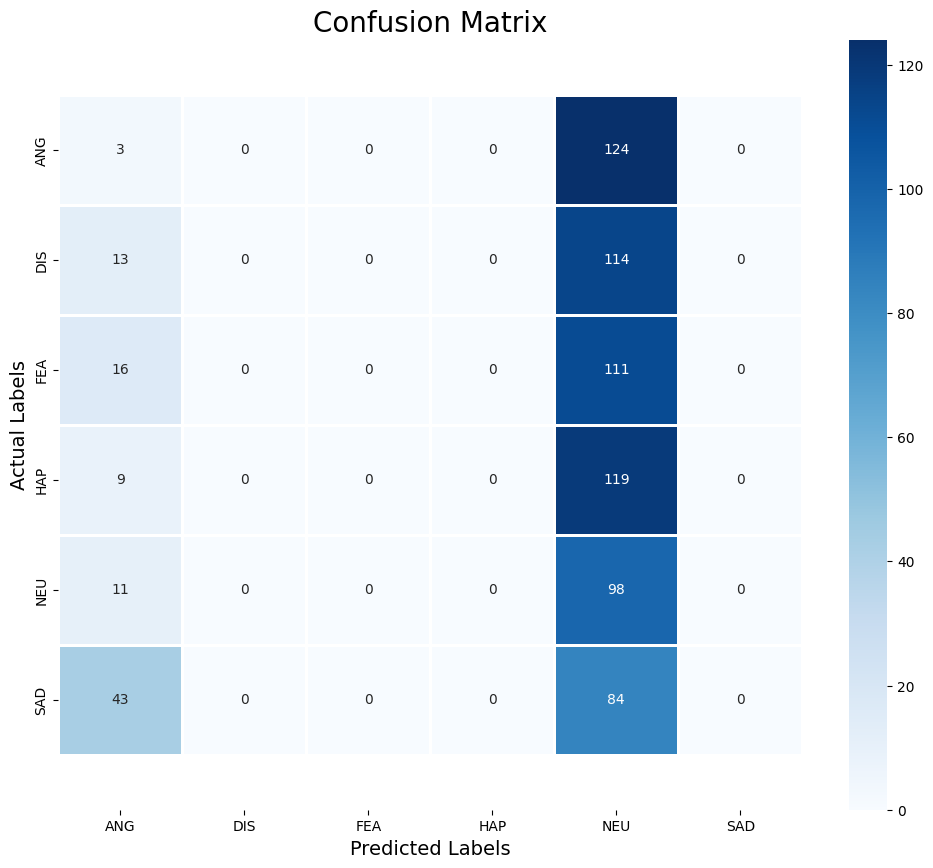

In [ ]:
cm = confusion_matrix(actual, predictions_ano)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Anonymized_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions_ano, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

              precision    recall  f1-score   support

         ANG       0.03      0.02      0.03       127
         DIS       0.00      0.00      0.00       127
         FEA       0.00      0.00      0.00       127
         HAP       0.00      0.00      0.00       128
         NEU       0.15      0.90      0.26       109
         SAD       0.00      0.00      0.00       127

    accuracy                           0.14       745
   macro avg       0.03      0.15      0.05       745
weighted avg       0.03      0.14      0.04       745



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
train_meta, test_meta = train_test_split(
    metadata_df, test_size=0.1, random_state=42, stratify=metadata_df['emotion']
)
test_meta["predict val"] = predictions
test_meta["predict val anonym"] = predictions_ano
test_meta.to_csv('test_set_predictions.csv', index=False)

# Utility

In [ ]:
# Installing necessary dependencies
%%capture
! pip install git+https://github.com/openai/whisper.git
! pip install jiwer

In [ ]:
# Importing modules
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import whisper
from whisper.normalizers import EnglishTextNormalizer
import torch
import jiwer
from tqdm.notebook import tqdm
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Loading whisper model
model = whisper.load_model("medium.en").to(device)
options = whisper.DecodingOptions(language='en', without_timestamps=True)

100%|█████████████████████████████████████| 1.42G/1.42G [00:23<00:00, 64.0MiB/s]


In [ ]:
train_meta, test_meta = train_test_split(
    metadata_df, test_size=0.1, random_state=42, stratify=metadata_df['emotion']
)
print(test_meta.shape)

(745, 4)


In [ ]:
abbreviation_to_text = {
    "IEO": "It's eleven o'clock",
    "TIE": "That is exactly what happened",
    "IOM": "I'm on my way to the meeting",
    "IWW": "I wonder what this is about",
    "TAI": "The airplane is almost full",
    "MTI": "Maybe tomorrow it will be cold",
    "IWL": "I would like a new alarm clock",
    "ITH": "I think I have a doctor's appointment",
    "DFA": "Don't forget a jacket",
    "ITS": "I think I've seen this before",
    "TSI": "The surface is slick",
    "WSI": "We'll stop in a couple of minutes"
}

In [ ]:
hypotheses = []
references = []

for file_path in test_meta["relative_path"]:
    file_path = file_path.replace("AudioWAV", "anonym-AudioWAV-2")
    print(file_path)
    # Extract the abbreviation (e.g., IEO)
    filename = os.path.basename(file_path)
    print(filename)
    parts = filename.split("_")
    abbreviation = parts[1]  # e.g., IEO

    # Map abbreviation to reference text
    reference_text = abbreviation_to_text.get(abbreviation, "")
    print(reference_text)

    # Load audio file

    audio_waveform, _ = librosa.load(file_path, sr=16000)
    audio_waveform = whisper.pad_or_trim(audio_waveform)
    audio_tensor = torch.tensor(audio_waveform, dtype=torch.float32).to(device)
    print(audio_tensor.shape)

    if audio_tensor.ndim > 1:
        audio_tensor = audio_tensor.mean(dim=0)

    mel = whisper.log_mel_spectrogram(audio_tensor).to(device)
    print(mel.shape)
    result = model.decode(mel, options)

    hypotheses.append(result.text)
    references.append(reference_text)

anonym-AudioWAV-2/1070_WSI_FEA_XX.wav
1070_WSI_FEA_XX.wav
We'll stop in a couple of minutes
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1015_DFA_NEU_XX.wav
1015_DFA_NEU_XX.wav
Don't forget a jacket
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1079_DFA_DIS_XX.wav
1079_DFA_DIS_XX.wav
Don't forget a jacket
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1057_IEO_SAD_HI.wav
1057_IEO_SAD_HI.wav
It's eleven o'clock
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1079_WSI_HAP_XX.wav
1079_WSI_HAP_XX.wav
We'll stop in a couple of minutes
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1030_DFA_FEA_XX.wav
1030_DFA_FEA_XX.wav
Don't forget a jacket
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1086_ITS_NEU_XX.wav
1086_ITS_NEU_XX.wav
I think I've seen this before
torch.Size([480000])
torch.Size([80, 3000])
anonym-AudioWAV-2/1079_ITH_HAP_XX.wav
1079_ITH_HAP_XX.wav
I think I have a doctor's appointment
torch.

In [ ]:
normalizer = EnglishTextNormalizer()

In [ ]:
# Normalizing references
clean_references = [normalizer(text) for text in references]

In [ ]:
clean_hypotheses = [normalizer(text) for text in hypotheses]

wer = jiwer.wer(clean_references, clean_hypotheses)
print("WER:", round(wer, 4)*100, "%")

WER: 34.910000000000004 %
